# PyTorch快速入门
# 1 搭建第一个神经网络

定义网络时，需要继承父类`nn.Module`，调用父类的初始化函数`__init__`，并实现它的`forward`函数，把网络中具有可学习参数的层放在构造函数`__init__`中。如果某一层(如`ReLU`)不具有可学习的参数，则既可以放在构造函数中，也可以不放，但建议不放在其中，而在`forward`中使用`nn.functional`代替。

定义一个简单的卷积神经网络`LeNet`:

## 1.1 网络结构

![11](imgs\lenet.png)

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module): # 定义一个子类Net，并继承父类nn.module。
    
    def __init__(self): # 定义初始化方法__init__。
        
        super(Net, self).__init__() # 等价于nn.Module.__init__(self) 
                                    # 调用父类的初始化函数__init__。
        
        # 卷积层    
        self.conv1 = nn.Conv2d(1, 6, 5) # 输入通道为1（即灰度图），输出通道为6（即分别与六个滤波器做卷积），滤波器大小为5*5)
        self.conv2 = nn.Conv2d(6, 16, 5) # conv2d表示输入为二维的卷积层。注意：torch中不支持一维的卷积运算。
        
        # 全连接层/仿射层，y = Wx + b
        self.fc1 = nn.Linear(16*5*5, 120) # 定义fc1（fullconnect）全连接函数1为线性函数：y = Wx + b，并将16*5*5个节点连接到120个节点上。
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # 输入x经过卷积conv1之后，经过激活函数ReLU，使用2x2的窗口进行最大池化Max_pool2d，然后更新到x。
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # 输入x经过卷积conv2之后，经过激活函数ReLU，使用2*2的窗口进行最大池化Max_pool2d,然后更新到x。
        x = x.view(x.size()[0], -1) # view函数将池化后的[batch*6*5*5]四维张量x,变形成根据batch数的[x.size()[0],-1]二维形式，其中-1表示自适应。总特征数并不改变，为接下来的全连接作准备。
        x = F.relu(self.fc1(x)) # 输入x经过全连接fc1后，经过激活函数ReLU输出给x。
        x = F.relu(self.fc2(x)) # 输入x经过全连接fc2后，经过激活函数ReLU输出给x。
        x = self.fc3(x) # 输入x经过全连接fc3后，输出给x。
        return x # 返回值x。
    
net = Net() # 创建一个Net的实例net。

print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [54]:
params = list(net.parameters()) # 网络的可学习参数通过net.parameters()返回。
print(len(params))

10


In [55]:
for name,parameters in net.named_parameters(): # net.named_parameters可同时返回可学习的参数及名称,相当于一个字典。
    print(name,':',parameters.size())   

conv1.weight : torch.Size([6, 1, 5, 5])
conv1.bias : torch.Size([6])
conv2.weight : torch.Size([16, 6, 5, 5])
conv2.bias : torch.Size([16])
fc1.weight : torch.Size([120, 400])
fc1.bias : torch.Size([120])
fc2.weight : torch.Size([84, 120])
fc2.bias : torch.Size([84])
fc3.weight : torch.Size([10, 84])
fc3.bias : torch.Size([10])


## 1.2 损失函数

In [56]:
input = torch.randn(1, 1, 32, 32) # 输入一个随机生成的样本。
out = net(input) # 输出
input.size(),out.size() #输入和输出的都是Tensor。

(torch.Size([1, 1, 32, 32]), torch.Size([1, 10]))

In [57]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1) # 转换为[1, n]的二维张量，-1表示自适应。
criterion = nn.MSELoss() # 均方误差作为损失函数。
loss = criterion(output, target)
loss # lost是个scalar

tensor(1.0804, grad_fn=<MseLossBackward>)

In [58]:
net.zero_grad() # 把net中所有可学习参数的梯度清零
print('反向传播之前 conv1.bias的梯度')
print(net.conv1.bias.grad)
loss.backward()
print('反向传播之后 conv1.bias的梯度')
print(net.conv1.bias.grad)

反向传播之前 conv1.bias的梯度
None
反向传播之后 conv1.bias的梯度
tensor([-0.0040, -0.0139, -0.0007, -0.0048, -0.0026,  0.0118])


## 1.3 优化器

在反向传播计算完所有参数的梯度后，还需要使用优化方法来更新网络的权重和参数，例如随机梯度下降法(SGD)的更新策略如下：

weight = weight - learning_rate * gradient

手动实现如下：

In [59]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate) # inplace 减法

torch.optim中实现了深度学习中绝大多数的优化方法，例如RMSProp、Adam、SGD等，更便于使用，因此大多数时候并不需要手动写上述代码。

In [60]:

import torch.optim as optim
#新建一个优化器，指定要调整的参数和学习率
optimizer = optim.SGD(net.parameters(), lr = 0.01)

# 在训练过程中
# 先梯度清零(与net.zero_grad()效果一样)
optimizer.zero_grad() 

# 计算损失
output = net(input)
loss = criterion(output, target)

#反向传播，计算梯度。
loss.backward()

#更新参数，学习率乘梯度。
optimizer.step()

# 2 CIFAR-10分类

流程：
1. 数据处理
2. 构建网络
3. 训练网络
4. 测试网络

## 2.1 数据处理

CIFAR-10[^1]是一个常用的彩色图片数据集，它有10个类别: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'。每张图片都是$3\times32\times32$，也即3-通道彩色图片，分辨率为$32\times32$。
[^1]: http://www.cs.toronto.edu/~kriz/cifar.html

[百度网盘下载](https://pan.baidu.com/s/1G4Eh5PyDHYnlrlcUDHtEfw)

In [3]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage

In [4]:
# 第一次运行程序torchvision会自动下载CIFAR-10数据集，
# 大约163M，需花费一定的时间
# 如果已经下载有CIFAR-10，可通过root参数指定

# 定义对数据的预处理方式
transform = transforms.Compose([
        transforms.ToTensor(), # 把一个取值范围是[0,255]的PIL.Image或者shape为(H,W,C)的numpy.ndarray，转换成形状为[C,H,W]，取值范围是[0,1.0]的torch.FloadTensor。
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化。Normalize(mean,std)：这里有三个通道，每个通道减去均值后除以标准差。
                             ])

# 训练集
trainset = tv.datasets.CIFAR10(
                    root = 'H:/Data/CIFAR-10/', 
                    train = True, 
                    download = True,
                    transform = transform)

#################参数说明#################
# root : cifar-10-batches-py 的根目录
# train : True = 训练集； False = 测试集 
# download :  True = 从互联上下载数据，并将其放在root目录下。如果数据集已经下载，什么都不干。
# transform : A function/transform = 将PIL(python image library) image进行转换。
# target_transform : A function/transform = 对target（即标签）进行转换。 
#########################################

trainloader = torch.utils.data.DataLoader(  #数据加载器。组合数据集和采样器，并在数据集上提供单进程或多进程迭代器。
                    trainset, 
                    batch_size = 4,
                    shuffle = True, 
                    num_workers = 2)

#################参数说明#################
# dataset (Dataset) – 加载数据的数据集。
# batch_size (int, optional) – 每个batch加载多少个样本(默认: 1)。
# shuffle (bool, optional) – 设置为True时会在每个epoch（整个训练集被遍历的次数）重新打乱数据(默认: False).
# sampler (Sampler, optional) – 定义从数据集中提取样本的策略。如果指定，则忽略shuffle参数。
# num_workers (int, optional) – 用多少个子进程加载数据。0表示数据将在主进程中加载(默认: 0)
# collate_fn (callable, optional) – 合并一个示例列表以形成一个Mini-batch。
# pin_memory (bool, optional) – 如果为True，数据加载器将把张量复制到CUDA固定内存中，然后返回它们
# drop_last (bool, optional) – 如果数据集大小不能被batch size整除，则设置为True后可删除最后一个不完整的batch。如果设为False并且数据集的大小不能被batch size整除，则最后一个batch将更小。(默认: False)
#########################################

# 测试集
testset = tv.datasets.CIFAR10(
                    'H:/Data/CIFAR-10/',
                    train = False, 
                    download = True, 
                    transform = transform)

testloader = torch.utils.data.DataLoader(
                    testset,
                    batch_size = 4, 
                    shuffle = False,
                    num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck') # classes是一个元组，对应dataset的标签。

Files already downloaded and verified
Files already downloaded and verified


tuple

Dataset对象是一个数据集，可以按下标访问，返回形如(data, label)的数据。

ship


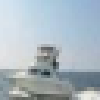

In [7]:
(data, label) = trainset[100]
print(classes[label]) # 打印对应label的标签。

show = ToPILImage() # 可以把Tensor转成PIL.Image，方便可视化
show((data + 1) / 2).resize((100, 100)) # (data + 1) / 2是为了还原被归一化的数据

Dataloader是一个可迭代的对象，它将dataset返回的每一条数据拼接成一个batch，并提供多线程加速优化和数据打乱等操作。当程序对dataset的所有数据遍历完一遍之后，相应的对Dataloader也完成了一次迭代。

        cat       horse        deer        ship


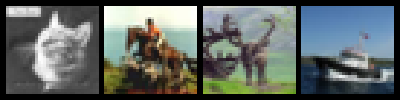

In [100]:
dataiter = iter(trainloader) # 因trainloader的shuffle参数设置为True，所以每次迭代时每个batch的内容被打乱。
images, labels = dataiter.next() # 返回4张图片及标签
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

## 2.2 构建网络

拷贝上面的LeNet网络，修改self.conv1第一个参数为3通道，因CIFAR-10是3通道彩图。

In [17]:
# 网络结构
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1   = nn.Linear(16*5*5, 120)  
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x

net = Net()

use_cuda = True # 是否使用GPU。

if use_cuda: 
    net = net.cuda()

print(net)
   
# 损失函数和优化器
from torch import optim
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # 随机梯度下降，        

############ 优化tricks之动量法参数momentum ############
# 一般，神经网络在更新权值时，采用公式为： w = w - learning_rate * dw
# 引入momentum后，采用公式为： w = momentum * w - learning_rate * dw
# 其在平坦的区域收敛会加快
######################################################

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 2.3 训练网络

In [26]:
torch.set_num_threads(8) # 获得用于并行化CPU操作的OpenMP线程数
for epoch in range(2):  #训练两个epoch。即两次遍历训练集。
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # 输入数据
        inputs, labels = data # 数据加载器生成的data为一个list，其包含两个元素，第一个是inputs值，第二个是labels值
        
        if use_cuda: # 是否使用GPU。
            inputs, labels = inputs.cuda(), labels.cuda()
        
        # 梯度清零
        optimizer.zero_grad()
        
        # forward + backward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()   
        
        # 更新参数 
        optimizer.step()
        
        # 打印log信息
        # loss 是一个scalar,需要使用loss.item()来获取数值，不能使用loss[0]，否则返回的是一个tensor
        running_loss += loss.item()
        if i % 2000 == 1999: # 每2000个batch打印一下训练状态
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 2000)) # 每两千次训练的平均损失。
            running_loss = 0.0
print('Finished Training') 

[1,  2000] loss: 2.205
[1,  4000] loss: 1.810
[1,  6000] loss: 1.674
[1,  8000] loss: 1.564
[1, 10000] loss: 1.480
[1, 12000] loss: 1.469
[2,  2000] loss: 1.385
[2,  4000] loss: 1.365
[2,  6000] loss: 1.350
[2,  8000] loss: 1.289
[2, 10000] loss: 1.289
[2, 12000] loss: 1.270
Finished Training


## 2.4 测试网络

实际的label: 
        cat       ship       ship      plane


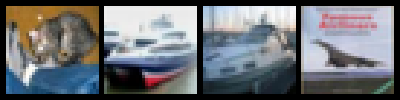

In [74]:
dataiter = iter(testloader)
images, labels = dataiter.next() # 一个batch返回4张图片

print('实际的label: ' '\n' , ' '.join('%10s' % classes[labels[j]] for j in range(4)))

if use_cuda: # 是否使用GPU。
    images, labels = images.cuda(), labels.cuda()
    
show(tv.utils.make_grid((images.to('cpu')+1) / 2)).resize((400,100)) # 用.to('cpu')将cuda Tensor转换为普通的Tensor来画图

In [75]:
# 计算图片在每个类别上的分数
outputs = net(images)
# 得分最高的那个类
_, predicted = torch.max(outputs.data, 1) # torch.max(Tensor, dimension(optional))输出Tensor中指定维度最大值及其索引
print('预测结果: ' '\n', ' '.join('%10s'% classes[predicted[j]] for j in range(4)))

预测结果: 
       frog        car       ship      plane


看一下全局错误率：

In [77]:
correct = 0 # 预测正确的图片数
total = 0 # 总共的图片数


# 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        if use_cuda: # 是否使用GPU。
            images, labels = images.cuda(), labels.cuda()
            
        outputs = net(images)
        _, predicted = torch.max(outputs, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum() # (predicted == labels)是一个Tensor，为真时值为1，假时值为0。

print('10000张测试集中的准确率为: %d %%' % (100 * correct / total))

10000张测试集中的准确率为: 55 %


比随机猜测百分之十要好，说明算法是有效的。

## 2.5 GPU训练

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device命名。如果多个CPU有待补充，TODO。

net.to(device) # 将网络存入显存
inputs = inputs.to(device) # 将训练时的输入存入显存
labels = labels.to(device) # 将标签存入显存
images = images.to(device) # 将测试时的输入存入显存